# Logistic Regression w/Cross Validation

### Import required packages

In [142]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import matplotlib.pylab as plt

from dmba import classificationSummary, gainsChart, liftChart

#### The Credit Approval dataset consists of actual credit card applications and their status for either approval or denial. The predictors have been anonymized to protect confidential information about the applicants.

### Load the data and perform initial inspection

In [143]:
data_df = pd.read_csv('credit_approval.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [144]:
data_df.head(20)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,Target
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,202,0,Approved
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,43,560,Approved
2,a,24.5,0.500,u,g,q,h,1.500,t,f,0,f,g,280,824,Approved
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,100,3,Approved
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,120,0,Approved
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,360,0,Approved
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,164,31285,Approved
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,80,1349,Approved
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,180,314,Approved
9,b,42.5,4.915,y,p,w,v,3.165,t,f,0,t,g,52,1442,Approved


In [145]:
data_df.shape

(690, 16)

In [146]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      690 non-null    object 
 1   V2      690 non-null    object 
 2   V3      690 non-null    float64
 3   V4      690 non-null    object 
 4   V5      690 non-null    object 
 5   V6      690 non-null    object 
 6   V7      690 non-null    object 
 7   V8      690 non-null    float64
 8   V9      690 non-null    object 
 9   V10     690 non-null    object 
 10  V11     690 non-null    int64  
 11  V12     690 non-null    object 
 12  V13     690 non-null    object 
 13  V14     690 non-null    object 
 14  V15     690 non-null    int64  
 15  Target  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [152]:
# Create a y response variable and an X collection of predictors

y = data_df['Target']

X = data_df.drop(columns=['Target'])

In [148]:
# Check the number of predictors before categorical encoding

print(len(X.columns))

15


In [153]:
# Convert the response variable from text to numbers

y = y.astype('category').cat.codes

In [150]:
# We'll try one-hot encoding first and check the dimensionality

X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [151]:
# Check the number of predictors after categorical encoding

print(len(X.columns))

559


In [154]:
# Encode categorical variables for least expansion after encoding

import category_encoders as ce

encoder = ce.CatBoostEncoder()

X = encoder.fit_transform(X, y)

In [28]:
print(len(X.columns))

15


In [155]:
# Check for a class imbalance

y.value_counts()

1    383
0    307
dtype: int64

### Cross Validated Explanatory Model using GridSearchCV

In [156]:
# Set up the parameter grid to use L2 regularization turned off through lambda (C)
# Solver can be liblinear and set class weight to none

param_grid = {
    'penalty': ['l2'],
    'C' : [1e42],
    'solver': ['liblinear'],
    'class_weight': [None],
}

In [157]:
gridSearch = GridSearchCV(LogisticRegression(), param_grid, cv=10)

gridSearch.fit(X, y)

print('Initial parameters: ', gridSearch.best_params_)

logit_reg = gridSearch.best_estimator_ # load the best cross-validated model into a new object

print()

print('intercept ', logit_reg.intercept_[0]) # print the intercept

print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns)) # print the coefficients

Initial parameters:  {'C': 1e+42, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

intercept  -1.9900381278466526
        coeff
V1  -0.581145
V2   0.086517
V3   0.015751
V4   0.172190
V5   0.172190
V6   1.043620
V7   0.003427
V8  -0.070917
V9   5.257345
V10  0.594034
V11 -0.199034
V12 -0.551189
V13 -0.458034
V14  0.648228
V15 -0.000444


#### Recreate X and y to remove prior categorical encoding; Train/test split with stratification of the response variable

In [158]:
# Create a y response variable and an X collection of predictors

y = data_df['Target']

X = data_df.drop(columns=['Target'])

In [159]:
y = y.astype('category').cat.codes

In [160]:
# Split the data into training and test sets (holdout approach)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [161]:
import category_encoders as ce

encoder = ce.CatBoostEncoder()

train_X = encoder.fit_transform(train_X, train_y)
test_X = encoder.transform(test_X)

In [162]:
train_X.shape

(345, 15)

In [163]:
train_y.value_counts()

1    191
0    154
dtype: int64

### Here are three different feature scaling algorithms - chose only one per model

In [164]:
# Feature Scaling with Standardization

from sklearn.preprocessing import StandardScaler

stand = StandardScaler()

train_X = stand.fit_transform(train_X)
test_X = stand.transform(test_X)

In [139]:
# Feature Scaling with Normalization

from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler(feature_range=(0,3))

train_X = norm.fit_transform(train_X)
test_X = norm.transform(test_X)

In [129]:
# Feature Scaling with Robust Scaling

from sklearn.preprocessing import RobustScaler

stand = RobustScaler(with_centering=True, with_scaling=True)

train_X = stand.fit_transform(train_X)
test_X = stand.transform(test_X)

### Predictive Model

In [165]:
logit_reg = LogisticRegressionCV(penalty="l2", Cs=100, solver='liblinear', class_weight = None, cv=10, 
                                 max_iter=5000, scoring="accuracy", random_state=1)

model = logit_reg.fit(train_X, train_y)

In [166]:
# we are only interested in classification accuracy

classificationSummary(train_y, model.predict(train_X))

classificationSummary(test_y, model.predict(test_X))

Confusion Matrix (Accuracy 0.8696)

       Prediction
Actual   0   1
     0 135  19
     1  26 165
Confusion Matrix (Accuracy 0.8493)

       Prediction
Actual   0   1
     0 137  16
     1  36 156


In [167]:
classes = model.predict(test_X)

print(metrics.classification_report(test_y, classes))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       153
           1       0.91      0.81      0.86       192

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       345
weighted avg       0.86      0.85      0.85       345



### Lift and Gain Charts

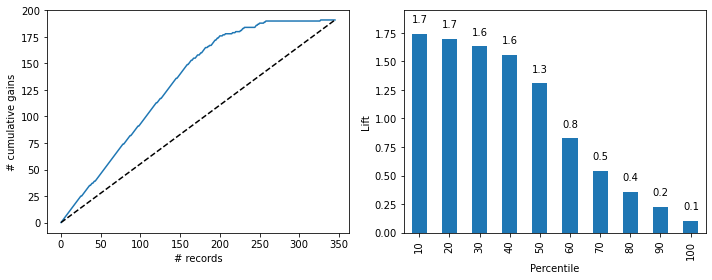

In [170]:
%matplotlib inline

logit_reg_pred = logit_reg.predict(train_X)
logit_reg_proba = logit_reg.predict_proba(train_X)
logit_result = pd.DataFrame({'actual': train_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

### ROC Chart

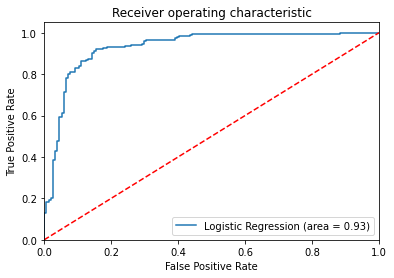

In [171]:
logit_reg_pred = logit_reg.predict(train_X)
logit_reg_proba = logit_reg.predict_proba(train_X)

preds = logit_reg_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(train_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()